# Tutorial 4: Comparison of SVD Solvers and Speed Performances

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/04_svd_solver_comparison.ipynb)

In this tutorial, you will learn:
- How to switch SVD solvers to use in the decomposition.
- How SVD solver can impact the computing speed performance of the decomposition.

## Data

* We use the `mortality` time series, which is a long time series, i.e., 11,688 data points, representing daily mortality in Belgium.

In [1]:
import time

from ssalib import SingularSpectrumAnalysis
from ssalib.datasets import load_mortality

count    11688.000000
mean       292.826489
std         40.832590
min        196.000000
25%        265.000000
50%        287.000000
75%        313.000000
max        675.000000
Name: CNT, dtype: float64


<Axes: xlabel='DATE_DEATH'>

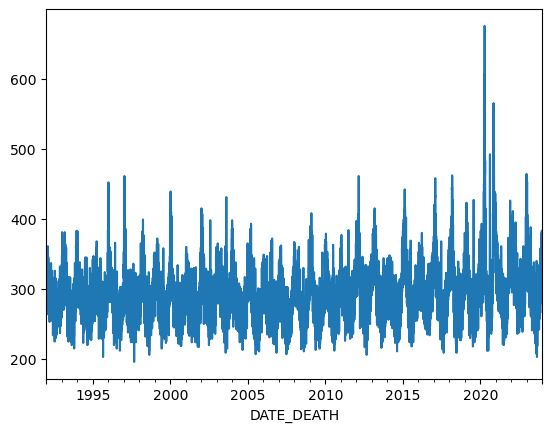

In [2]:
mortality = load_mortality()
print(mortality.describe())
mortality.plot()

## Effect of Time Series Length on Decomposition Speed

- We measure how the length of a time series affects the computation speed of the decomposition.
- A utility function, `measure_elapsed_time`, is used to average the performance over multiple runs.

In [3]:
def measure_elapsed_time(func, *args, n_repeat=10):
    """Measure the average speed performance of a function"""
    total_time = 0
    for _ in range(n_repeat):
        start_time = time.time()
        func(*args)
        total_time += time.time() - start_time
    return total_time / n_repeat

In [4]:
# Performance analysis
def performance_analysis(svd_solver='numpy_standard', n_components=None):
    for i in range(1,7):
        ts = mortality.iloc[:i*365] # 1 to 6 years of data
        myfunc = lambda x: SingularSpectrumAnalysis(x, svd_solver=svd_solver).decompose(
            n_components=n_components
        )
        print(
            f"Time series length: {i*365} days, "
            f"Averaged elapsed time: {measure_elapsed_time(myfunc, ts):.2f} seconds"
        )
performance_analysis()

Time series length: 365 days, Averaged elapsed time: 0.01 seconds
Time series length: 730 days, Averaged elapsed time: 0.02 seconds
Time series length: 1095 days, Averaged elapsed time: 0.06 seconds
Time series length: 1460 days, Averaged elapsed time: 0.11 seconds
Time series length: 1825 days, Averaged elapsed time: 0.18 seconds
Time series length: 2190 days, Averaged elapsed time: 0.32 seconds


- As the length of the time series increases, the computational time increases significantly (~quadratic scaling).
- For very large datasets, computational efficiency becomes crucial.
- Besides the timeseries length, the `window` and the `svd_matrix_kind`parameters may also influence the decomposition speed.
- Additional solver specific arguments may also have an impact.

## Using Different Solvers

- SSALib supports multiple SVD solvers:
    - `numpy_standard`: [`numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)
    - `scipy_standard`: [`scipy.linalg.svd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html)
    - `scipy_sparse`: [`scipy.sparse.linalg.svds`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html)
    - `sklearn_randomized`: [`sklearn.utils.extmath.randomized_svd`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html)

- The solver can be selected with the `svd_solver` argument.
- The available solver names are also available with the `available_solvers` property.
- User can pass additional arguments, depending on what is authorized by the solver. You can click on the underlying method to access the documentation.

In [5]:
SingularSpectrumAnalysis.available_solvers

['numpy_standard', 'scipy_standard', 'scipy_sparse', 'sklearn_randomized']

* The default solver is 'numpy_standard', which is mapping to the svd method implemented in the numpy linalg module.
* The 'scipy_sparse' the 'sklearn_randomized' are truncated svd solver that may return slightly different results depending on the stability of the decomposition results; however, they are much faster (in particular, sklearn_randomized).
* Their performance can also vary depending on solver-specific arguments (access the documentation from the links above), in particular, the number of components `n_components` to consider.

In [6]:
for solver in SingularSpectrumAnalysis.available_solvers[1:]:
    print(f"{solver}", end="\n")
    if solver in ['scipy_sparse', 'sklearn_randomized']:
        n_components = 50
    else:
        n_components = None
    performance_analysis(solver, n_components=n_components)
    print(end="\n")

scipy_standard
Time series length: 365 days, Averaged elapsed time: 0.01 seconds
Time series length: 730 days, Averaged elapsed time: 0.02 seconds
Time series length: 1095 days, Averaged elapsed time: 0.05 seconds
Time series length: 1460 days, Averaged elapsed time: 0.10 seconds
Time series length: 1825 days, Averaged elapsed time: 0.18 seconds
Time series length: 2190 days, Averaged elapsed time: 0.30 seconds

scipy_sparse
Time series length: 365 days, Averaged elapsed time: 0.01 seconds
Time series length: 730 days, Averaged elapsed time: 0.02 seconds
Time series length: 1095 days, Averaged elapsed time: 0.03 seconds
Time series length: 1460 days, Averaged elapsed time: 0.04 seconds
Time series length: 1825 days, Averaged elapsed time: 0.06 seconds
Time series length: 2190 days, Averaged elapsed time: 0.07 seconds

sklearn_randomized
Time series length: 365 days, Averaged elapsed time: 0.01 seconds
Time series length: 730 days, Averaged elapsed time: 0.01 seconds
Time series length:

* Considering the full time series with 11,688 data points, the 'sklearn_randomized' method remains very fast.

In [7]:
ssa = SingularSpectrumAnalysis(mortality, svd_solver='sklearn_randomized')
# Randomized decomposition with sklearn
start_time = time.time()
ssa.decompose(n_components=50)
end_time = time.time()

print('sklearn_randomized:', f'{end_time - start_time:.2f} seconds')

sklearn_randomized: 1.13 seconds


* As a result using 'sklearn_randomized', the decomposition is truncated to the defined number of components (i.e., 50 in this case).

In [8]:
u, s, vt = ssa.decomposition_results
print(len(s))

50
